# Standardized EDA & Analysis: Diabetes 30-Day Readmission

This notebook performs a comprehensive **Exploratory Data Analysis (EDA)** and builds a predictive model for hospital readmissions.

## Objectives
1. **Inspection**: Understand dataset structure (100k+ records).
2. **Cleaning**: Standardize naming, handle missing values (categorical).
3. **EDA**: Deep dive into Readmission Rates by Demographics and Clinical factors.
4. **Modeling**: Logistic Regression with Feature Importance (SHAP).


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Visualization Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def add_annotations(ax):
    """Add value labels to bars/points."""
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{int(p.get_height())}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        fontsize=10, color='black', xytext=(0, 5), 
                        textcoords='offset points')


## 1. Data Loading & Inspection

In [73]:
try:
    df = pd.read_csv('diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv')
    print("Shape:", df.shape)
    display(df.head())
except FileNotFoundError:
    print("Dataset not found. Please check path.")

Shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## 2. Cleaning & Renaming
Standardizing to `snake_case`.

In [74]:
# Rename logic extracted from original notebook but standardized
df.columns = [c.lower().replace(' ', '_').replace('-', '_') for c in df.columns]

# Specific Maps
rename_map = {
    'patient_nbr': 'patient_id',
    'admission_type_id': 'admission_type',
    'discharge_disposition_id': 'discharge_disposition',
    'admission_source_id': 'admission_source',
    'time_in_hospital': 'length_of_stay'
}
df = df.rename(columns=rename_map)
print("Renamed features:", list(rename_map.values()))

# Handle '?' as NaN
df = df.replace('?', np.nan)

# Drop High Missing Cols (Weight, Payer Code, Medical Specialty)
drop_cols = ['weight', 'payer_code', 'medical_specialty']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

Renamed features: ['patient_id', 'admission_type', 'discharge_disposition', 'admission_source', 'length_of_stay']


## 3. Variable Classification

In [75]:
# Target Engineering: <30 days is the positive class
df['target'] = (df['readmitted'] == '<30').astype(int)

numerical_cols = ['length_of_stay', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
categorical_cols = ['race', 'gender', 'age', 'admission_type', 'discharge_disposition', 'admission_source', 'max_glu_serum', 'a1cresult', 'change', 'diabetesmed']

print("Target Balance:")
print(df['target'].value_counts(normalize=True))

Target Balance:
target
0    0.888401
1    0.111599
Name: proportion, dtype: float64


## 4. Univariate Analysis

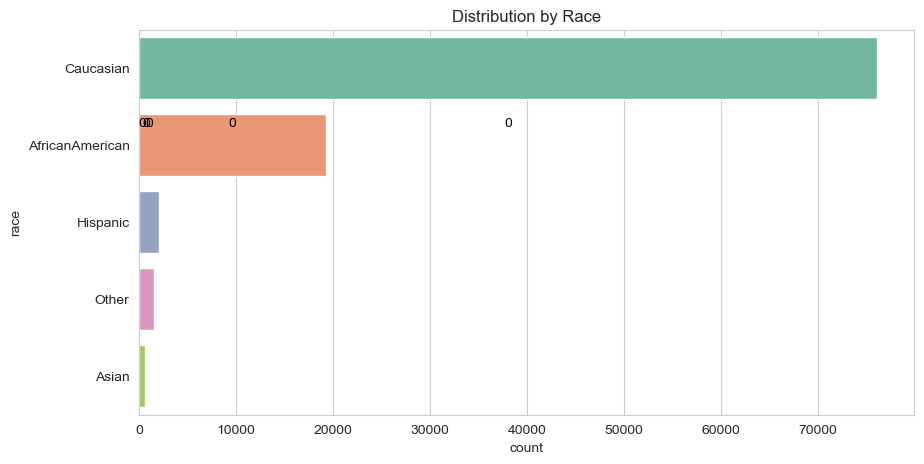

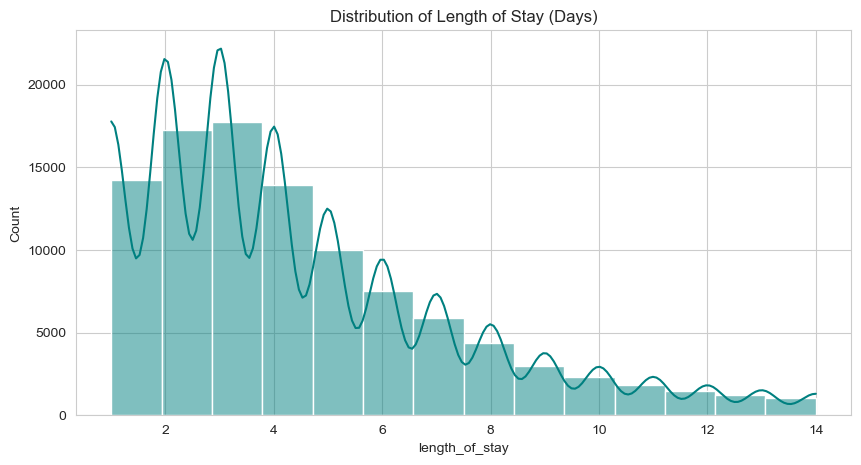

In [76]:
# 4.1 Categorical: Race
plt.figure(figsize=(10, 5))
ax = sns.countplot(y='race', data=df, order=df['race'].value_counts().index, palette='Set2')
plt.title('Distribution by Race')
add_annotations(ax)
plt.show()

# 4.2 Numerical: Length of Stay
plt.figure(figsize=(10, 5))
sns.histplot(df['length_of_stay'], bins=14, kde=True, color='teal')
plt.title('Distribution of Length of Stay (Days)')
plt.show()

## 5. Bivariate Analysis

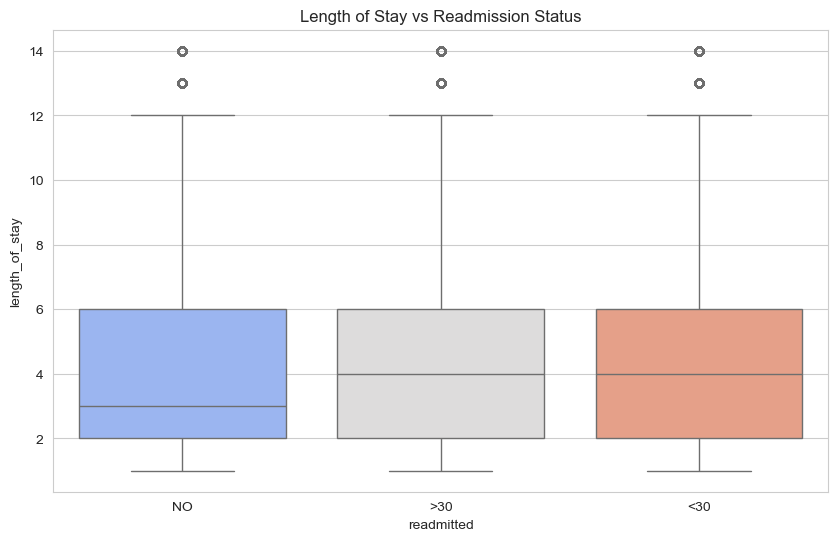

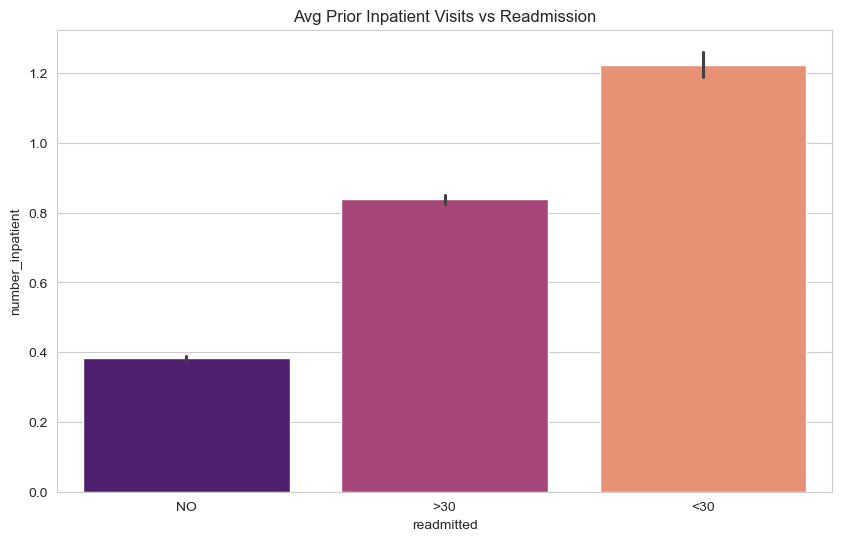

In [77]:
# 5.1 Readmission by Length of Stay
plt.figure(figsize=(10, 6))
sns.boxplot(x='readmitted', y='length_of_stay', data=df, palette='coolwarm')
plt.title('Length of Stay vs Readmission Status')
plt.show()

# 5.2 Readmission by Number of Inpatient Visits
plt.figure(figsize=(10, 6))
sns.barplot(x='readmitted', y='number_inpatient', data=df, palette='magma')
plt.title('Avg Prior Inpatient Visits vs Readmission')
plt.show()

## 6. Correlation Analysis

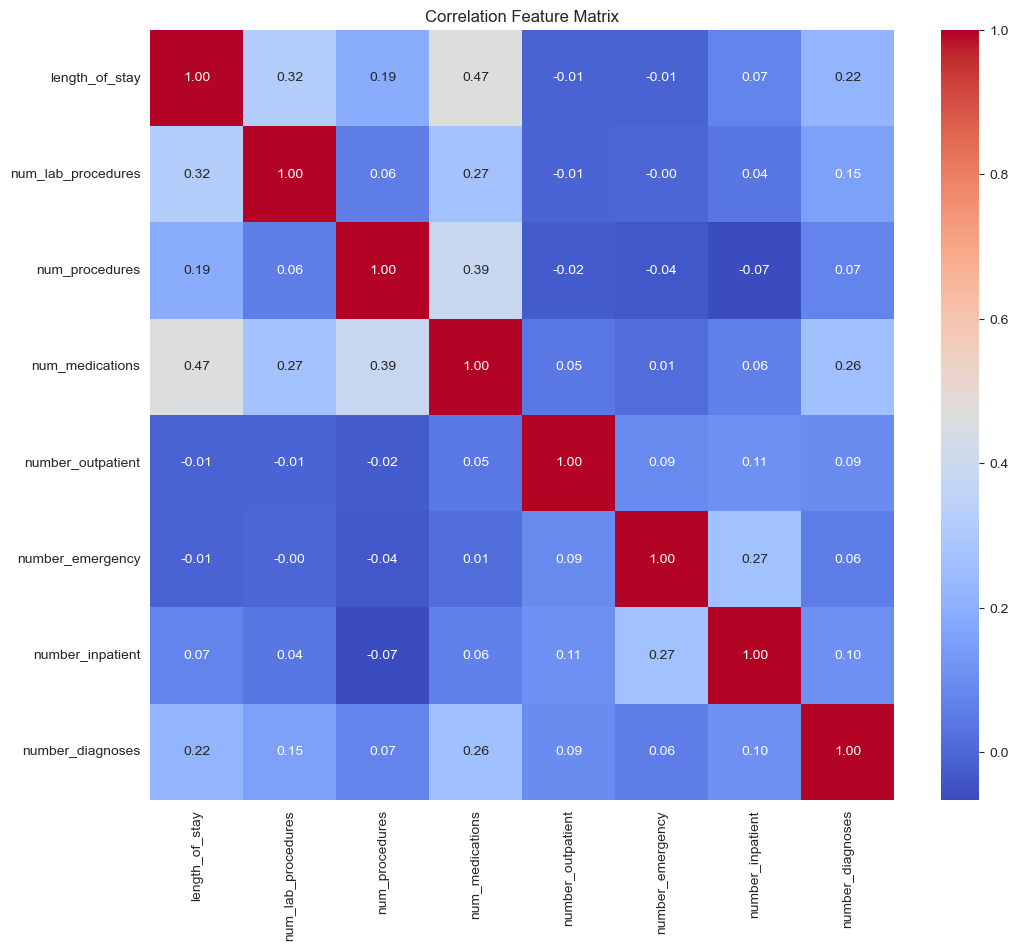

In [78]:
plt.figure(figsize=(12, 10))
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Feature Matrix')
plt.show()

## 7. Predictive Modeling (Preserved Logic)

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Simple Preprocessing for Model
X = df[numerical_cols].fillna(0)
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

preds = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, probs))
print(classification_report(y_test, preds))

ROC-AUC: 0.6307305099477047
              precision    recall  f1-score   support

           0       0.91      0.71      0.80     18069
           1       0.17      0.47      0.25      2285

    accuracy                           0.68     20354
   macro avg       0.54      0.59      0.52     20354
weighted avg       0.83      0.68      0.74     20354



## 8. Feature Importance
Identifying top drivers for readmission.

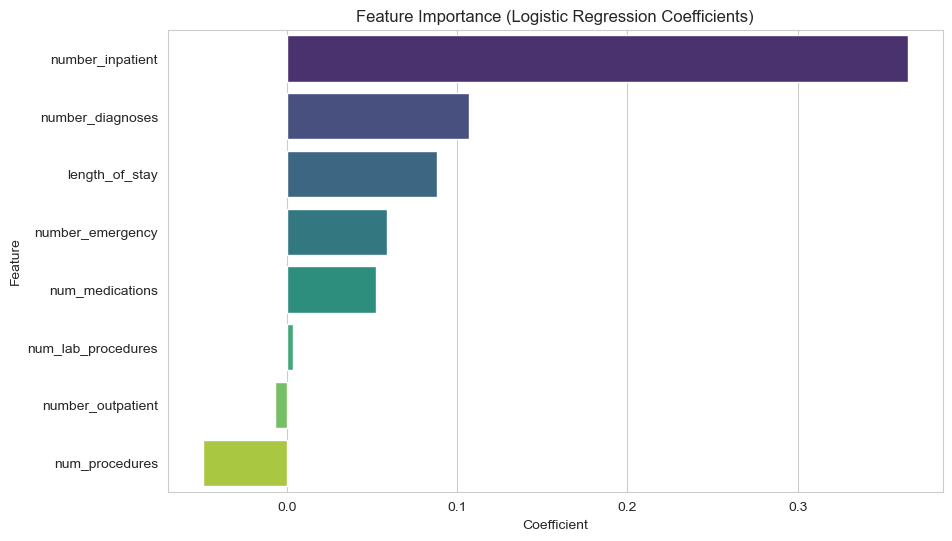

In [80]:
coeffs = pd.DataFrame({
    'Feature': numerical_cols,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coeffs, palette='viridis')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()